# Project for the Optimization for Data Science lecture

*Authors* : Alexandre Gramfort, Stéphane Gaiffas

## Objectives of the project

The aim of this project is to implement and use matrix factorization 
techniques to improve a classification problem. Namely, we will use the coefficients 
(also called codes or sparse codes below) as new features, instead of the raw features 
(here pixels from face images). The algorithms will be applied on a labelled face dataset.

## Description of the data

You will use the "Labeled Faces in the Wild" face recognition dataset.
This dataset is a collection of JPEG pictures of famous people collected over the internet,
all details are available on the official website: http://vis-www.cs.umass.edu/lfw/.
The downloading and preprocessing of the dataset is done is the code below.

## Step-by-step objectives 

1. Read and understand classification of the faces using the raw images
- Read and understand classification using features coming out of the SVD
- Code a routine doing (batch) dictionary learning
- Classification of the faces using the sparse code coming out of a dictionary learning as features.
- Compare all solutions in terms of accuracy of classification
- Try to improve the routine for dictionary learning using an online approach

## Notes

You will use **only** simple kNN (k-nearest neighbour) classification for the project.
The focus is on the benefits of using a matrix factorization technique (SVD, NMF, sparse dictionary learning) prior to a classification problem, to obtain better and more expressive features for classification.
In summary, the different methods to compare are the following:


1. kNN on raw features
- kNN on SVD/PCA features
- kNN on batch sparse dictionary learning features
- kNN on batch sparse dictionary learning features with non-negativity constraints
- kNN on online dictinoary learning features

## Evaluation

For evaluation of the project, we will look at what you have been able to implement, but also on the quality of your comments and explanations.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Download and load the face dataset

**NOTE**: this might take some time depending on your connection. 
Don't hesitate to wait and try several times.

In [3]:
from sklearn import decomposition

# fetch_lfw_people is the routine that download the data for you
from sklearn.datasets import fetch_lfw_people

# Download faces data
dataset = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# X contains the 1288 flattened images
X = dataset.data
# X contains the 1288 images of size (50, 37)
images = dataset.images
# y contains the targets: the label to be predicted
y = dataset.target
# target_names contains the name corresponding to the target
target_names = dataset.target_names

## Let's plot a subset of the data

In [4]:
images.shape

(1288, 50, 37)

The dataset contains $1288$ images of size $50 \times 37$ pixels. Let's plot the first ones.

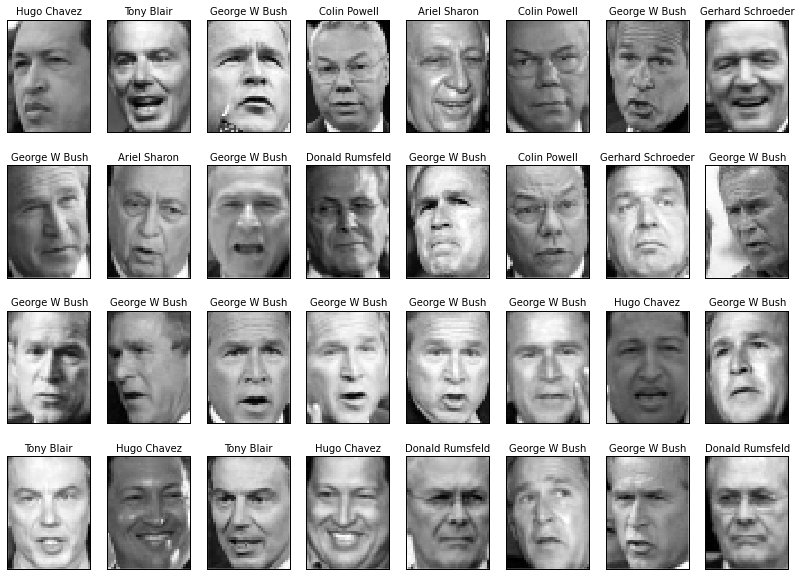

In [5]:
plt.figure(figsize=(14, 10))

n_rows, n_cols = 4, 8
for k in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, k + 1)
    plt.imshow(images[k], cmap=plt.cm.gray, interpolation='none')
    plt.xticks(())
    plt.yticks(())    
    plt.title(target_names[y[k]], size=10)

## Main objective

The aim will be to predict the label (name of the person's face) based on its picture.
To achieve this, we'll use a very simple classifier (kNN), but on features learned from a 
factorization of the $(1288 \times 1850)$ matrix `X` containing all flattened faces.
Once again, `images` contains the faces, while `X` contains the flattened faces.

This means that 

    X[k].reshape(50, 37)

is the same as

    images[k]

for all images `k` between 0 and 1287.

When applying matrix factorization and dictionary learning, it we will work on the flattened version below, contained in `X`, see below.

## Matrix factorization

Let us denote the number of samples $n$ and the number of features $p$ such that, following scikit-learn conventions, we have $X \in \mathbb{R}^{n \times p}$.

We are interested in factorizing the matrix $X^\top$ introducing a matrix $D \in \mathbb{R}^{p \times k}$ that we will call the *dictionary* and a matrix $A \in \mathbb{R}^{k \times n}$ that we will call the *code*. It is called the code as each column $i$ of $A$ contains the coeffecients for the sample $i$. The code is in dimension $k$ which corresponds to the number of columns in $D$. We will say that $k$ is the number of *atoms* in the dictionary.

The matrix $D$ and $A$ should verify that $X^\top \approx DA$

Matrix factorization in an unsupervised problem for which performance is hard to evaluate. In order to have an objective metric for the quality of the code $A$ we will use the code as new features using a k-NN (k=1) classifier.

We will now illustrate this using Singular Value Decomposition (SVD). The different variants of dictionary learning boil down to imposing different constraints on $D$ or $A$.

## Preprocessing : centering of the data

In [6]:
n_samples, n_features = X.shape

# global centering
X_centered = X - X.mean(axis=0)

# local centering
X_centered -= X_centered.mean(axis=1).reshape(n_samples, -1)

In [7]:
def plot_faces(faces, n_rows=4, n_cols=8, label=True):
    plt.figure(figsize=(14, 10))
    n_rows, n_cols = 4, 8
    face_shape = (50, 37)
    for k, flat_face in enumerate(faces):
        if k >= n_rows * n_cols:
            break
        face = flat_face.reshape(face_shape)
        plt.subplot(n_rows, n_cols, k+1)
        plt.imshow(face, cmap=plt.cm.gray, interpolation='none')
        plt.xticks(())
        plt.yticks(())
        if label:
            plt.title(target_names[y[k]], size=10)

The data looks that this now

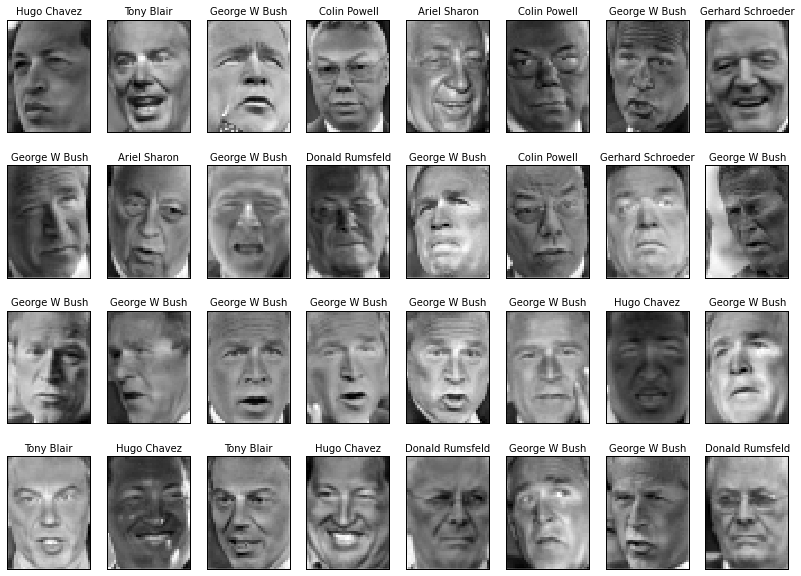

In [8]:
plot_faces(X_centered)

# Classification with kNN using the raw faces

First, we use a simple kNN classifier on the raw features (flattened faces, namely the lines of `X`). All evaluations are done by looking at the cross-validation score

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

# The kNN classifier
clf = KNeighborsClassifier(n_neighbors=1)

# Compute the cross-validation score of kNN on the raw features
scores_raw = cross_val_score(clf, X_centered, y, cv=2)
score_raw = np.mean(scores_raw)

print("Cross-validation score using raw features : %s" % scores_raw)

Cross-validation score using raw features : [ 0.58668731  0.62149533]


# Classification with kNN using the SVD features

In [63]:
from sklearn.decomposition import PCA
from scipy import linalg

# Apply SVD with on X_centered and get the D and A matrices
U, S, Vh = linalg.svd(X_centered.T, full_matrices=False)
D = U * S
A = Vh

Let's visualize the atoms

They look ugly... and are something referred to as "eigen faces".

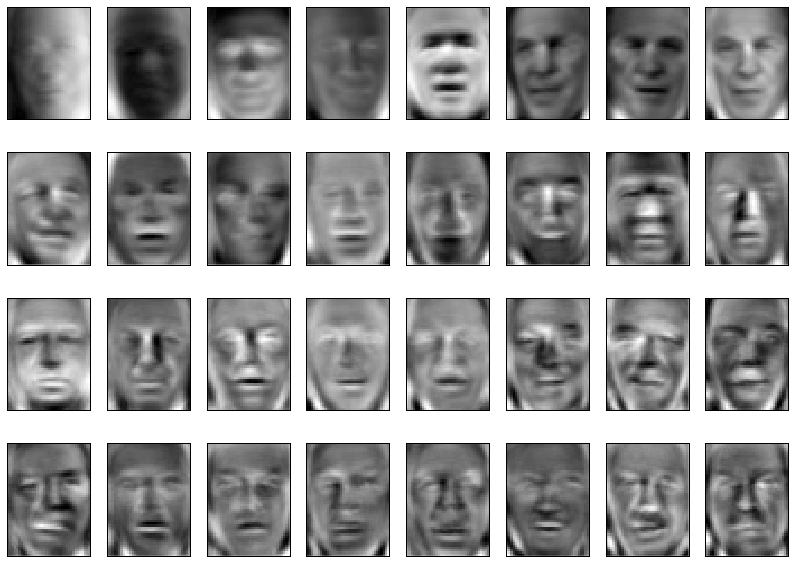

In [11]:
plot_faces(D.T, label=False)

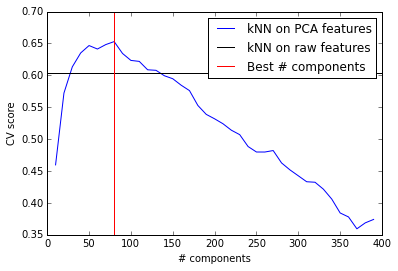

In [12]:
# Compute the cross-validation score of kNN on the new features obtained by PCA
clf = KNeighborsClassifier(n_neighbors=1)

scores_pca = []
n_components_range = np.arange(10, 400, 10)
for n_components in n_components_range:
    # n_components is the rank used in the SVD when fitting the PCA
    X_pca = A[:n_components, :].T
    score_pca = cross_val_score(clf, X_pca, y, cv=2).mean()
    scores_pca.append(score_pca)

plt.plot(n_components_range, scores_pca, label='kNN on PCA features')
plt.axhline(np.mean(score_raw), color='k', label='kNN on raw features')
plt.axvline(n_components_range[np.argmax(scores_pca)], color='r', label='Best # components')
plt.legend(loc='best')
plt.xlabel('# components')
plt.ylabel('CV score')

In summary, the features coming from SVD give a good improvement over the use of the raw features. Yet the atoms obtained with an SVD have no contraints: they don't have positive entries, and the new features don't have any sparsity properties. The idea is change the constraints on $D$ and $A$ during estimation to obtain good features.

# Classification with kNN using dictionary learning

The problem of sparse dictionary learning reads

$$
\min_{D,A} \frac{1}{2} \|X^\top - DA\|^2 + \lambda \|A\|_1
$$

under the constraints that the norm of each atom $\|D_i\| \le 1, \forall 1 \le i \le k$.
Here $\|A\|_1 = \sum_{i,j} |A_{ij}|$, i.e. it's the sum of the $\ell_1$ norm of each column of A.

This model was for example proposed in:

http://www.jmlr.org/papers/volume11/mairal10a/mairal10a.pdf

# YOUR MISSION :

- Propose and implement a method to estimate $D$ and $A$ by minimization of the sparse dictionary learning cost function. You will notice that the function to minimize is not jointly convex in $D$ and $A$ but that it is convex in $D$ when $A$ is fixed and convex in $A$ when $D$ is fixed. This suggests that you can use an alternated minimization technique.
- Apply the solver you developped above to obtain $D$ and $A$ by solving
$$
\min_{D,A} \frac{1}{2} \|X^\top - DA\|^2 + \lambda \|D\|_1
$$
subject to $\|A_i\| \le 1, \forall 1 \le i \le k$ (here $A_i$ stands for the $i^{th}$ row of $A$.
- As it was done with SVD above, evaluate the quality of the code with k-NN and visualize the atoms. What is the impact of the $\ell_1$ norm penalty on the atoms? You should observe that you will need to find a good $\lambda$.
- Add a non-negativity constraint on $D$ and $A$, i.e. $D_{ij} \geq 0$ and $A_{ij} \geq 0$. Does it improve the performance?
- Implement the online method from Mairal et al. (http://www.jmlr.org/papers/volume11/mairal10a/mairal10a.pdf).

WARNING: Some preprocessing of $X$ such as centering does not make sense if you use non-negativity constraints.

## Question 1
We are going to minimize A by the using the classic Lasso model. Then minimize D by Lagrange method. According to the previous TP, we know that the l_bfgs is the most performant method to minimize, so we use it to minize A.

In [203]:
from sklearn.preprocessing import normalize
from scipy.optimize import fmin_l_bfgs_b
from scipy.linalg import norm
k=20
n,p = X.shape
l1 = 0.5
D0 = normalize(np.random.rand(p,k),norm='l2',axis=0)
A0 = normalize(np.random.rand(k,n),norm='l1',axis=0)
lambda0=np.random.rand(k,1)

# Our aim is to find A and D so that we can minimize function f
def f(A,D):
    pobj=0.5*norm(X.T-D.reshape(p,k).dot(A.reshape(k,n)))**2+ l1* np.sum(abs(A))
    return pobj
def fprime(A,D):
    return (-D.reshape(p,k).T.dot(X.T-D.reshape(p,k).dot(A.reshape(k,n)))+l1*np.sign(A.reshape(k,n))).flatten()

# to update A
def A_sachantD(D):
    A = normalize(np.random.rand(k,n),norm='l1',axis=0).flatten()
    w,_,_=fmin_l_bfgs_b(f,A,fprime,args=(D,))
    w=w.reshape(k,n)
    return w

# to update D using Lagrange:



def D_sachantA(X, A):
    m=X.dot(A.T)
    
    def dual(d):       
        """The Lagrange dual function"""
        trans=np.linalg.inv(A.dot(A.T)+np.diagflat(d))
        dual=-np.trace(X.T.dot(X))+np.trace(m.dot(trans.dot(m.T)))+sum(d)
        return dual
    
    def dual_grad(d):
        """The gradient of dual function"""
        g=np.zeros(len(d))
        trans=np.linalg.inv(A.dot(A.T)+np.diagflat(d))
        for i in range(len(d)):
            g[i]=1-linalg.norm((m.dot(trans))[:,i]) ** 2
        return g   
    
            
    def dual_hess(d):
        """The Hessian of dual function"""
        H=np.ones(len(d))
        trans=np.linalg.inv(A.dot(A.T)+np.diagflat(d))
        M=np.dot(trans.dot(m.T),m.dot(trans))
        H=-2*M*trans
        return H  
    
    # using the 'Newton-CG' to find the solution of the dual problem
    d0=np.random.rand(A.shape[0],1)
    res = minimize(dual, d0, method='Newton-CG', jac=dual_grad, hess=dual_hess, options={'xtol': 1e-8, 'disp': True})
    
    # using the above solution to update D
    D=np.linalg.inv(A.dot(A.T)+np.diagflat(res.x)).dot(m.T)
    return D.T




f_value=[]
def solve1(A, D, n = 5):
    flag = False
    for i in range(2*n):
        if flag:
            D = D_sachantA(X.T, A)
            f_value.append(f(A,D))
            print "new D updated"
        else:
            A = A_sachantD(D)
            print "new A updated"
        flag = not flag
    return A,D

new A updated
         Current function value: -2410856036.739248
         Iterations: 51
         Function evaluations: 91
         Gradient evaluations: 129
         Hessian evaluations: 52
new D updated
new A updated
         Current function value: -1102304077.238249
         Iterations: 38
         Function evaluations: 56
         Gradient evaluations: 82
         Hessian evaluations: 39
new D updated
new A updated
         Current function value: -1055113326.446478
         Iterations: 33
         Function evaluations: 82
         Gradient evaluations: 103
         Hessian evaluations: 34
new D updated
new A updated
         Current function value: -1039995150.463373
         Iterations: 36
         Function evaluations: 106
         Gradient evaluations: 128
         Hessian evaluations: 37
new D updated
new A updated
         Current function value: -1032996049.744084
         Iterations: 30
         Function evaluations: 49
         Gradient evaluations: 67
         Hessian e

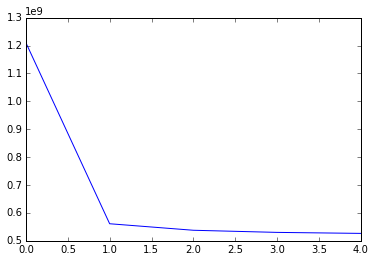

In [204]:
A,D=solve1(A0, D0)
plt.plot(f_value)

In [ ]:
from sklearn.preprocessing import normalize
from scipy.optimize import fmin_l_bfgs_b
from scipy.linalg import norm
k=20
n,p = X.shape
l1 = 10
D0 = normalize(np.random.rand(p,k),norm='l1',axis=0).flatten()
A0 = normalize(np.random.rand(k,n),norm='l2',axis=0).flatten()
lambda0=np.random.rand(k,1)
# Our aim is to find A and D so that we can minimize function f
def f(D,A):
    pobj=0.5*norm(X.T-D.reshape(p,k).dot(A.reshape(k,n)))**2+ l1* np.sum(abs(D))
    return pobj
def fprime(D,A):
    return (-(X.T-D.reshape(p,k).dot(A.reshape(k,n))).dot(A.reshape(k,n).T)+l1*np.sign(D.reshape(p,k))).flatten() 

# The lagrangian function 
def L(D,A,ld):
    obj = 0.5*norm(X.T-D.reshape(p,k).dot(A.reshape(k,n)))**2
    for i in range(k):
        obj += ld[i]*(norm(A.reshape(k,n).T[i])-1)
    return obj

# set dL(D,A,ld)/dA to zero, and go back to lagrangian function again
def Lag(lbd,D):
    b=np.dot(D.reshape(p,k).T,X.T)
    a=(D.reshape(p,k).T.dot(D.reshape(p,k))+2*np.diagflat(lbd)).T
    A=np.linalg.solve(a, b)
    obj=L(D,A,lbd)
    return -obj

# to update D
def D_sachantA(A):
    D = normalize(np.random.rand(p,k),norm='l1',axis=0).flatten()
    w,_,_=fmin_l_bfgs_b(f,D,fprime,args=(A,))
    return w

# to update A
def A_sachantD(D):
    w,_,_=fmin_l_bfgs_b(Lag,lambda0,approx_grad=True,args=(D0,),bounds=[(0,None)]*k)
    b=D.reshape(p,k).T.dot(X.T)
    a=(D.reshape(p,k).T.dot(D.reshape(p,k))+2*np.diagflat(w)).T
    Amin=np.linalg.solve(a, b)
    return Amin.T

f_value=[]
def Sparse_DL_2(A, D, n = 5):
    flag = False
    for i in range(2*n):
        if flag:
            D = D_sachantA(A)
            f_value.append(f(D,A))
            print "new D updated"
        else: 
            A = A_sachantD(D)
            print "new A updated"
        flag = not flag
    return A,D

In [ ]:
A,D=solve1(A0, D0)
plt.plot(f_value)

###Question 3 
#### Compute the cross-validation score of kNN on the new features obtained by 


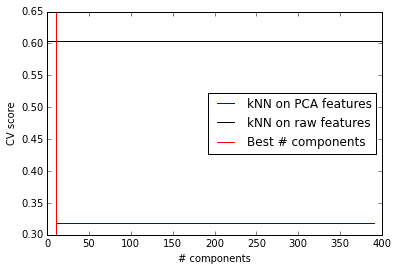

In [186]:
# Compute the cross-validation score of kNN on the new features obtained by PCA
clf = KNeighborsClassifier(n_neighbors=1)

scores_pca = []
n_components_range = np.arange(1, k, 1)
for n_components in n_components_range:
    # n_components is the rank 
    X_pca = A[:n_components, :].T
    score_pca = cross_val_score(clf, X_pca, y, cv=2).mean()
    scores_pca.append(score_pca)

plt.plot(n_components_range, scores_pca, label='kNN on PCA features')
plt.axhline(np.mean(score_raw), color='k', label='kNN on raw features')
plt.axvline(n_components_range[np.argmax(scores_pca)], color='r', label='Best # components')
plt.legend(loc='best')
plt.xlabel('# components')
plt.ylabel('CV score')

###Question 5
#### Compute the cross-validation score of kNN on the new features obtained by online dictionary algorithm




In [205]:
# Online learning algorithm
def f2(alpha,x_t,D):
    pobj=0.5*norm(x_t-D.dot(alpha))**2+ l1* np.sum(abs(alpha))
    return pobj

def fprime2(alpha,x_t,D):
    return (-D.T.dot(x_t-D.dot(alpha))+l1*np.sign(alpha))
            
def alpha_sachantD(D, x_t):
    alpha_0 = np.zeros(k)
    w,g,dic=fmin_l_bfgs_b(f2,alpha_0,fprime2,args=(x_t,D,))
    return w
A=np.zeros((k,k))
B=np.zeros((n_features,k))
D = normalize(np.random.rand(n_features,k),norm='l2',axis=0)
for t in range(n_samples):
    #print 't=',t
    alpha=alpha_sachantD(D,X[t])
    A=A+np.asmatrix(alpha).T.dot(np.asmatrix(alpha))
    B=B+np.asmatrix(X[t]).T.dot(np.asmatrix(alpha))
    for re in range(10):
        for j in range(k):
            u=1/A[j,j]*(B.T[j]-D.dot(A.T[j].T).reshape(1,n_features))+D.T[j]
            D.T[j]=1/max(norm(u),1)*u
        #print 're=',re        
            
# apdate A using the final updated dictionary

A = A_sachantD(D)





            

In [206]:
A.shape

(20, 1288)

(1288, 1)
0.253857913062
(1288, 2)
0.281039321779
(1288, 3)
0.260852791682
(1288, 4)
0.267044742147
(1288, 5)
0.320662500121
(1288, 6)
0.324556581117
(1288, 7)
0.350156245479
(1288, 8)
0.364977865224
(1288, 9)
0.382799012374
(1288, 10)
0.389731199907
(1288, 11)
0.419234590049
(1288, 12)
0.416143437208
(1288, 13)
0.403735424322
(1288, 14)
0.419316570701
(1288, 15)
0.438714639816
(1288, 16)
0.430181418362
(1288, 17)
0.437157007417
(1288, 18)
0.431724583587
(1288, 19)
0.432484110221


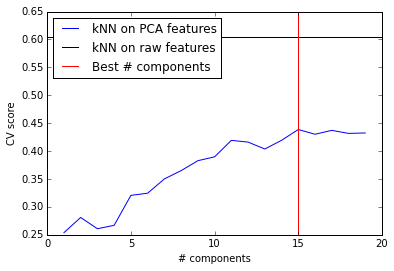

In [207]:
clf = KNeighborsClassifier(n_neighbors=1)

scores_pca = []
n_components_range = np.arange(1, k, 1)
for n_components in n_components_range:
    # n_components is the rank 
    X_pca = A[:n_components, :].T
    print X_pca.shape
    score_pca = cross_val_score(clf, X_pca, y, cv=2).mean()
    print score_pca
    scores_pca.append(score_pca)

plt.plot(n_components_range, scores_pca, label='kNN on PCA features')
plt.axhline(np.mean(score_raw), color='k', label='kNN on raw features')
plt.axvline(n_components_range[np.argmax(scores_pca)], color='r', label='Best # components')
plt.legend(loc='best')
plt.xlabel('# components')
plt.ylabel('CV score')